In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stat
import seaborn as sns
import scipy
from scipy.integrate import quad
from scipy.special import binom
import statsmodels.api as sm
import pylab

## Data Extraction

In [325]:
def create_dataframe():
    return pd.read_csv('hour.csv')
def df_wrapper():
    """
    
    """
    df = create_dataframe()
    df = df[df['holiday'] != 1 ]
    df = df[df['workingday'] == 1]

    #df = df[df['yr'] == 1]
    

    df = df[df['hr'].isin(np.arange(16,19+1))]
    df_spring = df[df['season'] == 2]
    df_summer = df[df['season'] == 3]

    return pd.concat([df_spring, df_summer])
    
def season_wrapper(df):
    """
    
    """
    df = df_wrapper()
    df_spring = df[df['season'] == 2]
    df_summer = df[df['season'] == 3]

    return df_spring, df_summer

def count_aggregator(df_hr):
    """ 
    
    """
    return df_hr['cnt'].groupby(df_hr['dteday']).sum()
 

def collect_data(df):
    """ 
    
    """
    df_spring, df_summer = season_wrapper(df)
    
    frames = {}
    frames['spring'], frames['summer'] = df_spring, df_summer
  
    for key in frames.keys():
        frames[key] = count_aggregator(frames[key])
    
    return frames
df_agg = df_wrapper()
df_agg
df_agg16 = df_agg[df_agg['hr']==16]
df_agg17 = df_agg[df_agg['hr']==17]
df_agg18 = df_agg[df_agg['hr']==18]
df_agg19 = df_agg[df_agg['hr']==19]


In [326]:
for col in df_agg.columns:
    print(f"{col} has NaN? ", df_agg[col].isnull().values.any())

instant has NaN?  False
dteday has NaN?  False
season has NaN?  False
yr has NaN?  False
mnth has NaN?  False
hr has NaN?  False
holiday has NaN?  False
weekday has NaN?  False
workingday has NaN?  False
weathersit has NaN?  False
temp has NaN?  False
atemp has NaN?  False
hum has NaN?  False
windspeed has NaN?  False
casual has NaN?  False
registered has NaN?  False
cnt has NaN?  False


In [331]:
def generate_quartiles(df):
    arr = np.zeros(df.shape[0])
    store_quartiles = {'windspeed' : arr, 'hum' : arr, 'weathersit' : arr, 'atemp' : arr}

    for feat in store_quartiles.keys():
        quartiles = np.ones(df.shape[0])
        for q in [25,50,75]:
            quartiles += np.where(df[str(feat)] > np.percentile(df[str(feat)], q), 1, 0)
        
        df[f"{feat}_code"] = quartiles
    
    return df

def outlier_detection(df):
    df = generate_quartiles(df)
    fig = plt.figure(figsize= (15,10))
    plt.title('Count vs Quartiles for Continuous Weather Data', fontweight = 'bold', fontsize=15)
    for idx, x in zip(range(221,225), ['weathersit_code', 'windspeed_code', 'hum_code', 'atemp_code']):
        ax1 = fig.add_subplot(idx)
        df = df.replace([2,3], ['Summer', 'Spring'])
        sns.boxplot(x=x, y='cnt', data=df, hue='yr')
    
    plt.show()

def inspect_hourly_means(df):
    for hr in np.unique(df['hr']):
    
        test = df[df['hr'] == hr]
        test = test[test['yr'] == 1]
        test = test[test['hr'] == hr]
        test_spring = test[test['season']==2]
        test_summer = test[test['season']==3]
        print(f"Spring: Mean(hr = {hr}) = {round(np.mean(test_spring['cnt']),2)}")
        print(f"Summer: Mean(hr = {hr}) = {round(np.mean(test_summer['cnt']),2)}\n")



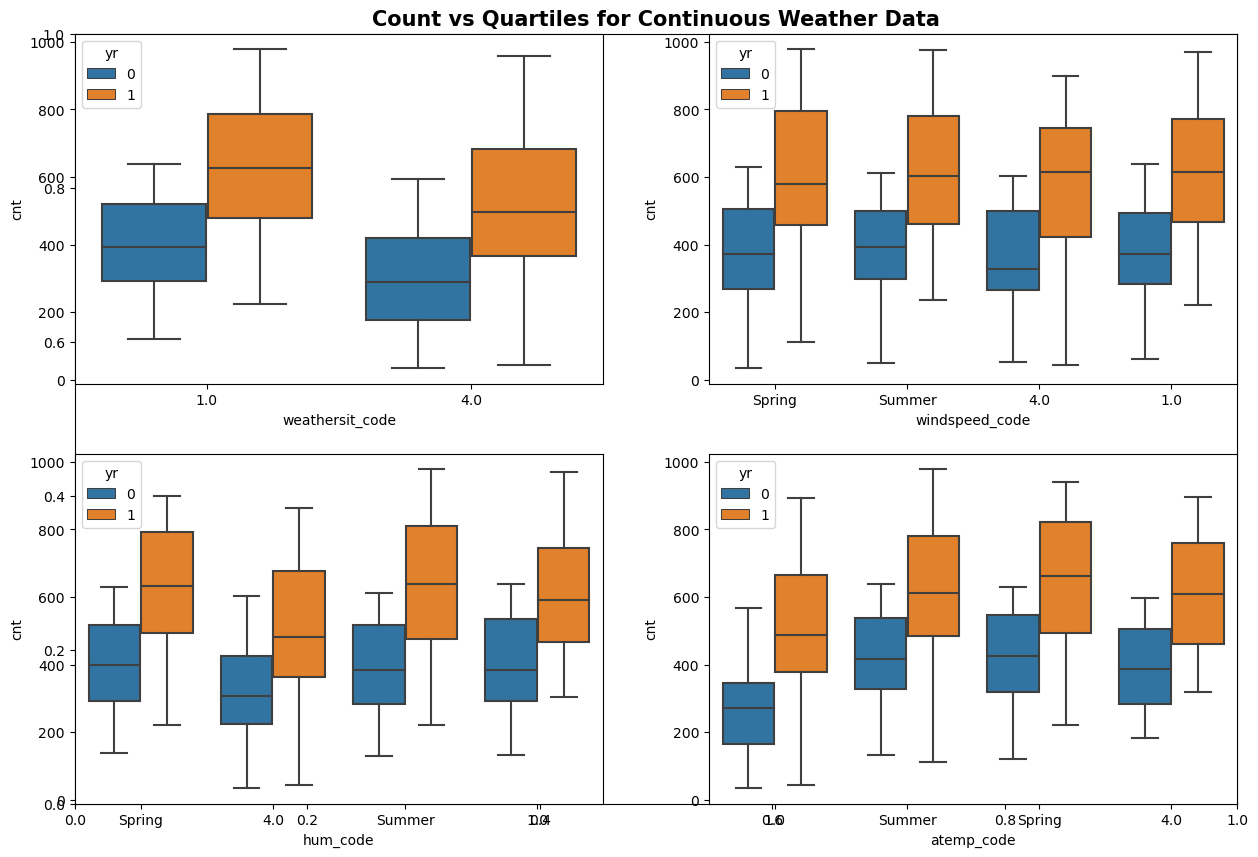

In [332]:
outlier_detection(df_agg)

In [333]:
df_agg

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,atemp,hum,windspeed,casual,registered,cnt,windspeed_code,hum_code,weathersit_code,atemp_code
1822,1823,2011-03-21,2,0,3,16,0,1,1,2,...,0.5152,0.64,0.2836,29,112,141,3.0,3.0,4.0,1.0
1823,1824,2011-03-21,2,0,3,17,0,1,1,2,...,0.5152,0.64,0.2537,41,231,272,3.0,3.0,4.0,1.0
1824,1825,2011-03-21,2,0,3,18,0,1,1,2,...,0.5000,0.72,0.2239,44,232,276,2.0,4.0,4.0,1.0
1825,1826,2011-03-21,2,0,3,19,0,1,1,1,...,0.5455,0.60,0.4179,22,199,221,4.0,3.0,1.0,1.0
1846,1847,2011-03-22,2,0,3,16,0,2,1,1,...,0.4848,0.42,0.1045,40,125,165,1.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14966,14967,2012-09-20,3,1,9,19,0,4,1,1,...,0.5455,0.60,0.2239,69,534,603,2.0,3.0,1.0,1.0
14987,14988,2012-09-21,3,1,9,16,0,5,1,1,...,0.6515,0.54,0.1940,103,464,567,2.0,3.0,1.0,2.0
14988,14989,2012-09-21,3,1,9,17,0,5,1,1,...,0.6364,0.57,0.2836,107,739,846,3.0,3.0,1.0,2.0
14989,14990,2012-09-21,3,1,9,18,0,5,1,1,...,0.6212,0.61,0.2537,106,699,805,3.0,3.0,1.0,2.0


In [334]:
inspect_hourly_means(df_agg)

Spring: Mean(hr = 16) = 390.47
Summer: Mean(hr = 16) = 438.8

Spring: Mean(hr = 17) = 705.66
Summer: Mean(hr = 17) = 796.66

Spring: Mean(hr = 18) = 674.5
Summer: Mean(hr = 18) = 764.95

Spring: Mean(hr = 19) = 481.92
Summer: Mean(hr = 19) = 562.86



# Plotting Functions for Comparing Distributions

In [349]:
from seaborn_qqplot import pplot
from sklearn import metrics
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats

def plot_hist_kde(df):
    """ 
    
    """
    # / TODO improve plotting
    #summer_cnt = count_aggregator(df[df['season'] == 3])
    #spring_cnt = count_aggregator(df[df['season'] == 2])
    summer = df[df['season'] == 3]
    spring = df[df['season'] == 2]

    plt.hist(x=summer['cnt'], color='blue', label='Summer', alpha=0.3, bins=15, density=True)
    plt.hist(x=spring['cnt'], color='red', label='Spring', alpha=0.3, bins=15, density=True)
    summer['cnt'].plot.kde()
    spring['cnt'].plot.kde()
    
    plt.legend()
    plt.title('Summer vs. Spring Bike Rental Distribution', fontweight='bold', fontsize=15)
    plt.show()
    
def plot_line(df):
    df = df.replace([2,3], ['Summer', 'Spring'])
    sns.lineplot(x='hr',y='cnt', data=df, palette = 'RdBu', hue='season')
    plt.title("Season Counts");

def plot_box(df):
    """ 
    
    """
    # / TODO improve plotting
    df = df.replace([2,3], ['Summer', 'Spring'])
    sns.boxplot(data=df, x='hr', y='cnt', hue='season')
    
def plot_qq(df):
    """ 
    
    """
    df = df.replace([2,3], ['Summer', 'Spring'])
    pplot(data=df, x='hr', y='cnt', hue='season', kind='qq', height=4, aspect=2, display_kws={"identity":False})

def mean_squared_error(sample1, sample2):
    """  
    
    """
    assert(len(sample1) == len(sample2))
    return round(np.sum( (1/len(sample1))*(sample1 - sample2)**2),5)

def plot_ecdf_norm(df):
    """ 
    
    """
    n = 233
    # /TODO improve plotting
    fig = plt.figure(figsize= (13,7))
    ax1 = fig.add_subplot(n)
    
    seasons = collect_data(df)
    input_cdf = np.linspace(-3,3,  len(seasons.get('summer')))
    theoretical_cdf = scipy.stats.norm.cdf(input_cdf)
    
    ax1.plot(input_cdf, theoretical_cdf, label='Normal CDF')
    
    for key in seasons.keys(): 
        arr = np.array(seasons[key])
        norm_arr = scipy.stats.zscore(arr)
        norm_arr.sort()
        empirical_cdf = np.arange(1,len(norm_arr)+1)/len(norm_arr)

        ax1.plot(norm_arr, empirical_cdf,label = f'S{key[1:]} Empirical CDF')
        
        try:
            mse_error = round(mean_squared_error(empirical_cdf, theoretical_cdf),4)
        
        except AssertionError:
        
            diff = abs(len(empirical_cdf) - len(theoretical_cdf))
        
            if len(theoretical_cdf) < len(empirical_cdf):
                empirical_cdf = empirical_cdf[diff:]
                norm_arr = norm_arr[diff:]
            else:
                theoretical_cdf = theoretical_cdf[diff:]
            
            mse_error = round(mean_squared_error(empirical_cdf, theoretical_cdf),4)
        
        print("Mean Squared Error Empirical vs Theoretical CDF: ", mse_error)
    vals_list = list(seasons.values())
    print(len(vals_list))
    y0 = vals_list[0]
    y1 = vals_list[1]
    print(len(y0), len(y1))
    print(np.mean(y0), np.mean(y1))
    
    try:
        print(f"Mean Squared Error Spring vs. Summer {mean_squared_error(y0, y1)}")
    except AssertionError:
        diff = abs(len(y0) - len(y1))
        
        if len(y0) < len(y1):
                y1 = y1[diff:]
        else:
            y0 = y0[diff:]
        
        print(f"Mean Squared Error Spring vs. Summer { mean_squared_error(y0, y1) }")

    ax1.set_title(label='Empirical vs Theoretical CDF', fontweight='bold')
    
    plt.legend(loc='best')
    plt.tight_layout()

def plot_ecdf(df):
    cnt_spring = count_aggregator(df[df['season'] == 2])
    cnt_summer = count_aggregator(df[df['season'] == 3])
    spring = ECDF(cnt_spring)
    summer = ECDF(cnt_summer)
    plt.plot(spring.x, spring.y, color='blue', label='ECDF spring')
    plt.plot(summer.x, summer.y, color='red', label='ECDF summer')
    plt.tight_layout()
    plt.title('Empirical Cumulative Distribution Function')
    plt.legend()
    plt.show()

# Visuals for Comparing Distributions

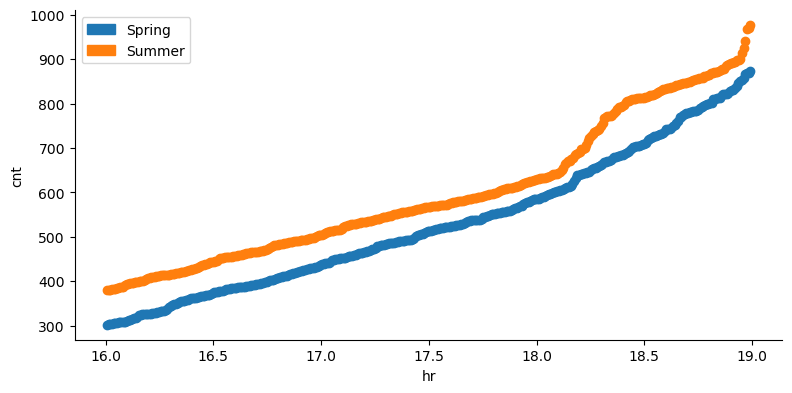

In [350]:
plot_qq(df_agg)

16


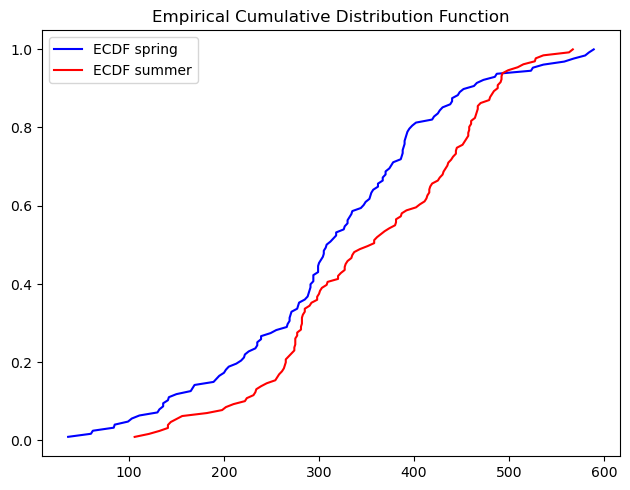

17


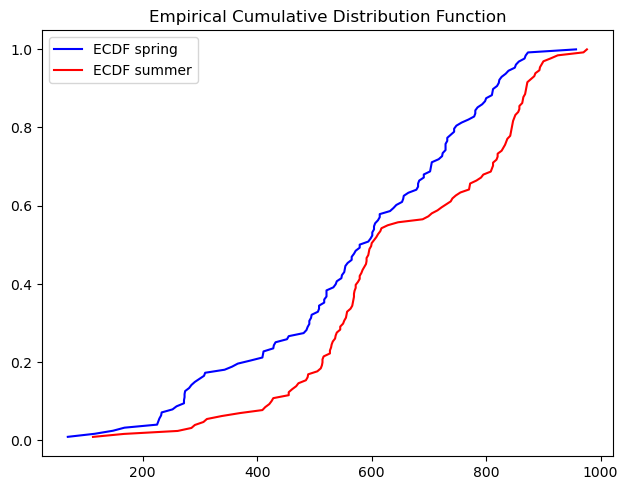

18


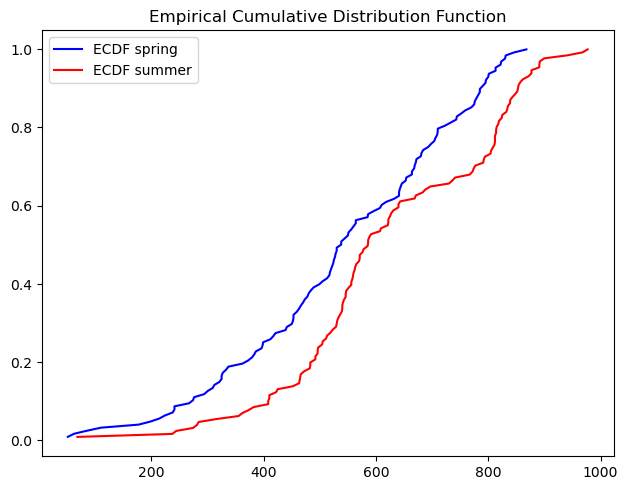

19


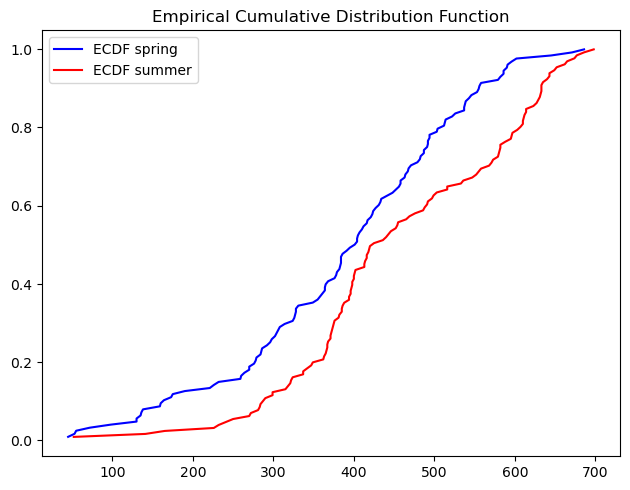

In [351]:
for hr, test in zip([16,17,18,19], [df_agg16, df_agg17, df_agg18, df_agg19]):
    print(hr)
    plot_ecdf(test)

In [352]:
df_agg.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,1036.0,8396.160232,4568.334890,1823.0000,4029.7500,6244.5000,12780.2500,14991.0000
season,1036.0,2.505792,0.500208,2.0000,2.0000,3.0000,3.0000,3.0000
yr,1036.0,0.498069,0.500238,0.0000,0.0000,0.0000,1.0000,1.0000
mnth,1036.0,6.177606,1.795141,3.0000,5.0000,6.0000,8.0000,9.0000
hr,1036.0,17.500000,1.118574,16.0000,16.7500,17.5000,18.2500,19.0000
holiday,1036.0,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
weekday,1036.0,3.042471,1.393613,1.0000,2.0000,3.0000,4.0000,5.0000
workingday,1036.0,1.000000,0.000000,1.0000,1.0000,1.0000,1.0000,1.0000
weathersit,1036.0,1.328185,0.623545,1.0000,1.0000,1.0000,1.0000,3.0000
temp,1036.0,0.683668,0.138138,0.2600,0.6000,0.7200,0.7800,0.9800


16


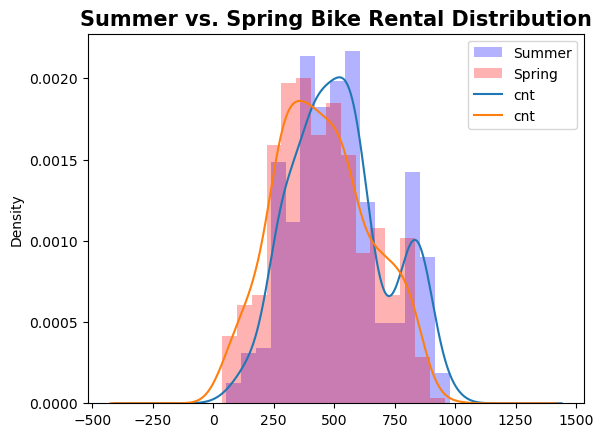

17


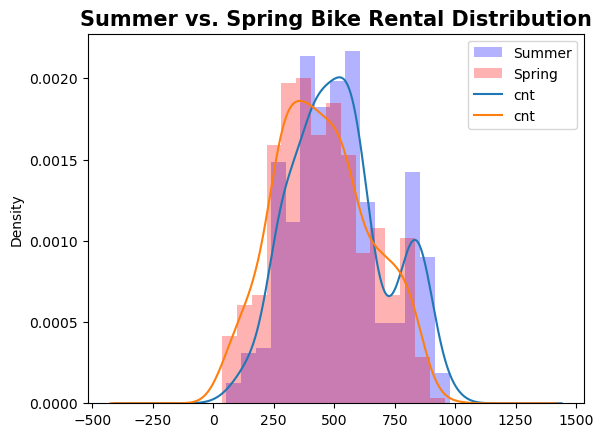

18


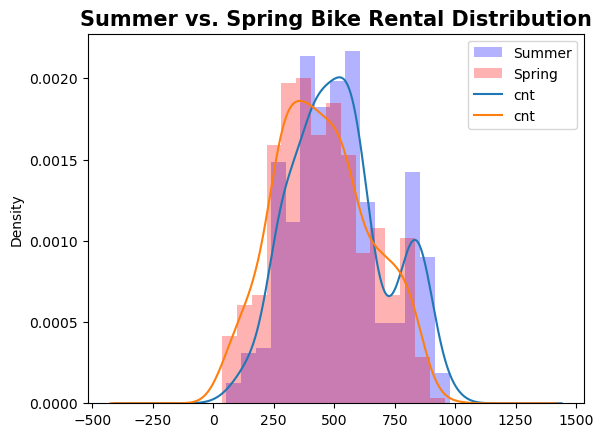

19


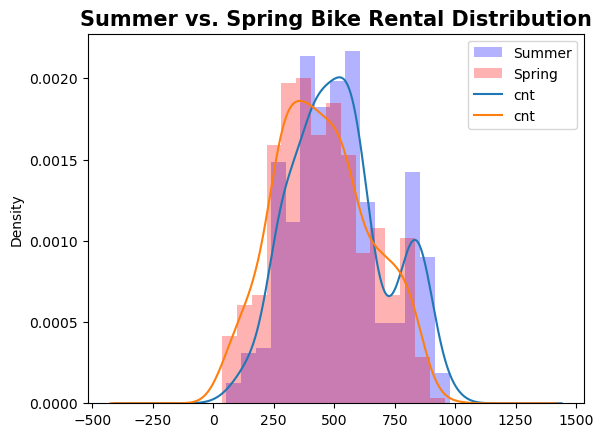

In [353]:
for hr, test in zip([16,17,18,19], [df_agg16, df_agg17, df_agg18, df_agg19]):
    print(hr)
    plot_hist_kde(df_agg)

# Shapiro-Wilk Test
inspired by https://math.mit.edu/~rmd/465/shapiro.pdf

In [359]:
def norm_expectation_rank(r, n):
    """ 
    
    """
    inf, phi, Phi = float('inf'), stat.NormalDist().pdf, stat.NormalDist().cdf
    def f(x):

        F = Phi(x)
        return x*(1-F)**(r-1)*F**(n-r)*phi(x)
    return r*binom(n, r)*quad(f, -inf, inf)[0]

def expected_val_arr(arr, dict_return=False):
    n = len(arr)
    if not dict_return:
        return np.array([norm_expectation_rank(k+1, n+1) for k in range(n)])
    else:
        return {f"expected val rank {k+1}" : norm_expectation_rank(k+1, n+1) for k in range(n)}

def cov_matrix(arr):
    n = len(arr)
    # TODO confirm covariance matrix
    # see https://apps.dtic.mil/dtic/tr/fulltext/u2/a053857.pdf
    # this requires a tedious implementation which I don't consider worthwhile
    
    return np.eye(N=len(arr), M=len(arr))

def test_statistic(seasons):
    for key in seasons.keys():
        
        x = np.array(seasons[key])
        # normalize
        x = (x - np.mean(x))/ np.std(x)
        x.sort()
        
        assert(np.isclose(np.mean(x), 0))
        assert(np.isclose(np.std(x), 1))

        n = len(x)
        # TODO inspect correctness in this function
        m = expected_val_arr(x)
        
        # Covariance matrix is incorrect, need to investigate how to calculate.
        # see TODO under function
        V = cov_matrix(m)
        
        assert(V[i][j] == V[j][i] for i in range(n) for j in range(n))
        
        normalizing_const = np.sqrt(m.T @ np.linalg.inv(V) @ np.linalg.inv(V) @ m)
        
        a = m.T @ np.linalg.inv(V) / normalizing_const
        W = (x @ a)**2 / np.sum( (x - np.mean(x))**2 )
        
        print(str.capitalize(key))
        print("Sum a: ", np.sum(a))
        print("Sum m: ", np.sum(m))
        print(f"Lower bound = {(n*(a[0]**2))/(n+1)}")
        print(f"Wilk test statistic = {W}\n")

for hr, test in zip([16,17,18,19], [df_agg16, df_agg17, df_agg18, df_agg19]):
    print(f"Hour = {hr}")
    filtered_seasons = collect_data(test)
    test_statistic(filtered_seasons)


Hour = 16
Spring
Sum a:  0.23750169992682946
Sum m:  2.5973010263361553
Lower bound = 0.055969793456754444
Wilk test statistic = 0.9799130972908133

Summer
Sum a:  0.23533213574797163
Sum m:  2.605274439525246
Lower bound = 0.05496165946331171
Wilk test statistic = 0.9523477928529509

Hour = 17
Spring
Sum a:  0.23750169992682946
Sum m:  2.5973010263361553
Lower bound = 0.055969793456754444
Wilk test statistic = 0.9799130972908133

Summer
Sum a:  0.23533213574797163
Sum m:  2.605274439525246
Lower bound = 0.05496165946331171
Wilk test statistic = 0.9523477928529509

Hour = 18
Spring
Sum a:  0.23750169992682946
Sum m:  2.5973010263361553
Lower bound = 0.055969793456754444
Wilk test statistic = 0.9799130972908133

Summer
Sum a:  0.23533213574797163
Sum m:  2.605274439525246
Lower bound = 0.05496165946331171
Wilk test statistic = 0.9523477928529509

Hour = 19
Spring
Sum a:  0.23750169992682946
Sum m:  2.5973010263361553
Lower bound = 0.055969793456754444
Wilk test statistic = 0.97991309729

# Kolmogorov-Smirnov Test
inspired by http://www.math.utah.edu/~davar/ps-pdf-files/Kolmogorov-Smirnov.pdf 

(To be developed)

In [362]:
for hr, test in zip([16,17,18,19], [df_agg16, df_agg17, df_agg18, df_agg19]):
    print(f"Hour = {hr}")
    filtered_seasons = collect_data(test)
    print(scipy.stats.mannwhitneyu(filtered_seasons['spring'], filtered_seasons['summer']))
    print(scipy.stats.kstest(filtered_seasons['spring'], filtered_seasons['summer']))
    

Hour = 16
MannwhitneyuResult(statistic=6251.0, pvalue=0.000403214810370146)
KstestResult(statistic=0.21576812977099236, pvalue=0.0038461890541387467)
Hour = 17
MannwhitneyuResult(statistic=6251.0, pvalue=0.000403214810370146)
KstestResult(statistic=0.21576812977099236, pvalue=0.0038461890541387467)
Hour = 18
MannwhitneyuResult(statistic=6251.0, pvalue=0.000403214810370146)
KstestResult(statistic=0.21576812977099236, pvalue=0.0038461890541387467)
Hour = 19
MannwhitneyuResult(statistic=6251.0, pvalue=0.000403214810370146)
KstestResult(statistic=0.21576812977099236, pvalue=0.0038461890541387467)


In [261]:
len(filtered_seasons['spring']) , len(filtered_seasons['summer'])

(640, 655)

In [354]:
import math
def combinations(n, r):
    return math.factorial(n) / ( math.factorial(n-r) * math.factorial(r) )

combinations(259, 131)

4.509444947331175e+76

# Permutation Test

In [263]:
# from statsmodels.distributions.empirical_distribution import ECDF

# d_ecdf_x = np.diff(ECDF(x, 'left').y)/np.diff(ECDF(x, 'left').x)
# d_ecdf_y = np.diff(ECDF(y, 'left').y)/np.diff(ECDF(y, 'left').y)
# variance = (1 / p) * ( 1 / ( ( 4*d_ecdf_x)**2) ) + (1 / (1 - p) ) * ( 1 / ( ( 4*d_ecdf_y)**2) )

In [271]:
print(np.median(filtered_seasons['spring']), np.median(filtered_seasons['summer']))
print(np.mean(filtered_seasons['spring']), np.mean(filtered_seasons['summer']))

382.5 446.0
405.5328125 464.6564885496183


In [363]:
from scipy import stats as st
import statistics as stat

def mean_stat(x, y):
    N = len(x) + len(y)
    p = len(x)/N
    q = len(y)/N
    
    assert(0.49 < q < 0.51)
    assert(0.49 < p < 0.51)
    var = np.sqrt( (N/len(x)) * np.var(x) +  (N/len(y)) * np.var(y))

    return np.sqrt( len(x) + len(y) ) * (np.mean(x) - np.mean(y)) / var

def var_stat(x, y):
    N = len(x) + len(y)
  
    var = np.sqrt( (N/len(x)) * np.var(x) +  (N/len(y)) * np.var(y))

    return  np.sqrt( len(x) + len(y) ) * (np.std(x) - np.std(y)) / var

def median_stat(x, y):
    
    N = len(x) + len(y)
    
    var = np.sqrt( (N/len(x)) * np.var(x) +  (N/len(y)) * np.var(y))
    
    return np.sqrt( len(x) + len(y) ) *  (np.median(x) - np.median(y)) / var

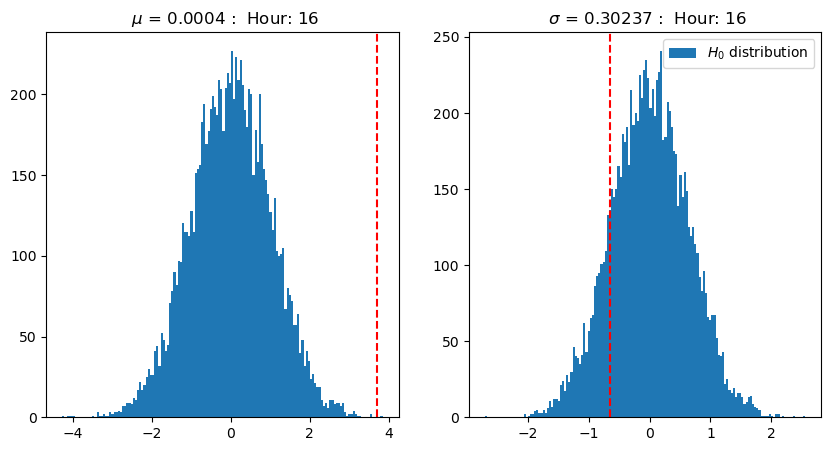

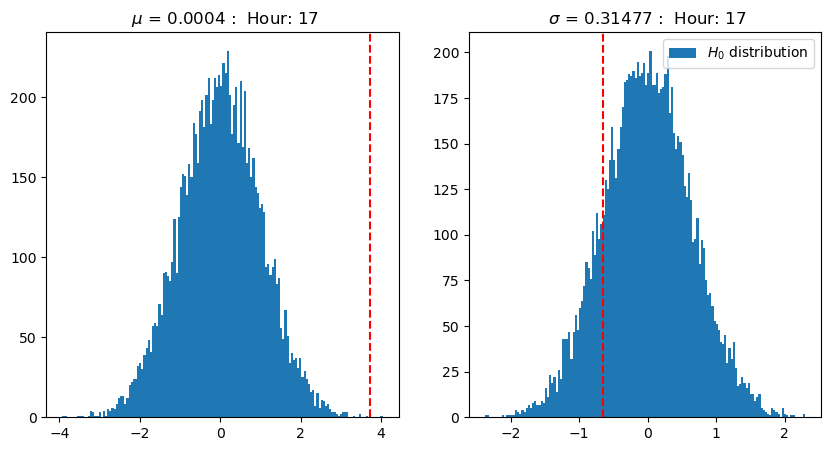

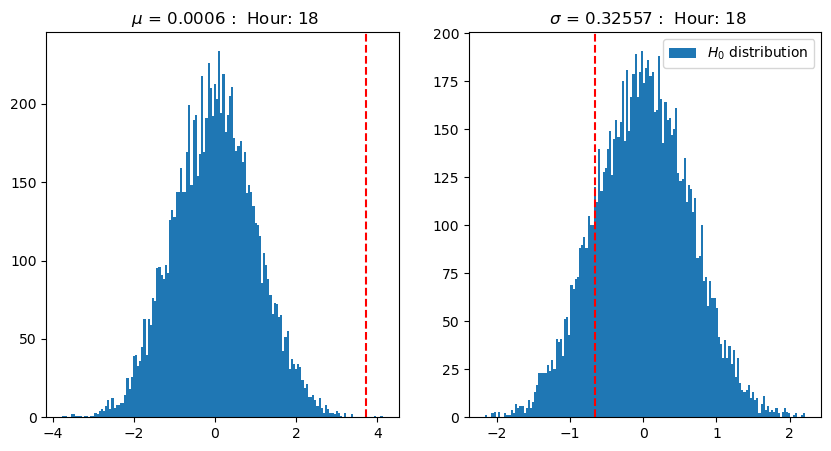

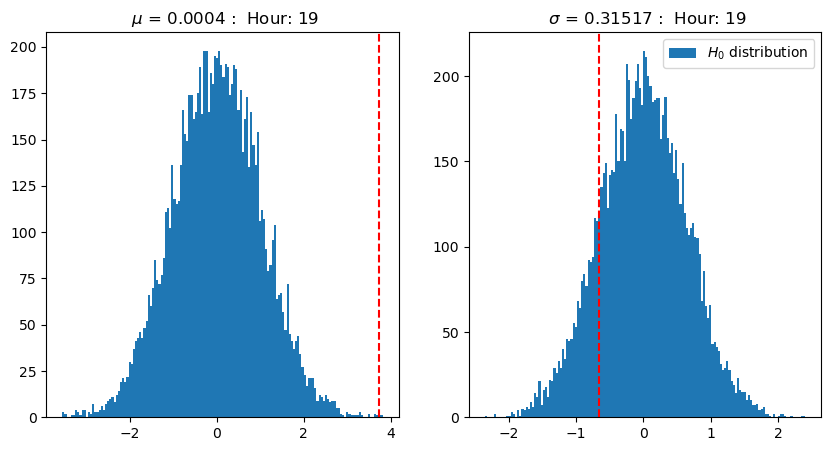

In [377]:
for hr, test in zip([16,17,18,19], [df_agg16, df_agg17, df_agg18, df_agg19]):

    res1 = st.permutation_test(data=(filtered_seasons['summer'], filtered_seasons['spring']), 
                        statistic=mean_stat,
                        n_resamples=10000,
                        permutation_type='independent',
                        alternative='two-sided'
                        )
    res2 = st.permutation_test(data=(filtered_seasons['summer'], filtered_seasons['spring']), 
                        statistic=var_stat,
                        n_resamples=10000,
                        permutation_type='independent',
                        alternative='two-sided'
                        )

    fig, ax = plt.subplots(1,2, figsize=(10,5))                     
    ax[0].hist(res1.null_distribution, bins=150, label='$H_{0}$ distribution')
    ax[0].axvline(x=res1.statistic, color = "red", linestyle='--', label='Test statistic')
    ax[1].hist(res2.null_distribution, bins=150, label='$H_{0}$ distribution')
    ax[1].axvline(x=res2.statistic, color = "red", linestyle='--')
    plt.legend(loc='best')
    ax[0].set_title(f' $\mu$ = {round(res1.pvalue, 5)} :  Hour: {hr}')
    ax[1].set_title(f' $\sigma$ = {round(res2.pvalue,5)} :  Hour: {hr}')
    plt.show()

In [ ]:
plt.hist(res3.null_distribution, bins=150, label='$H_{0}$ distribution')
plt.axvline(x=res3.statistic, color = "red", linestyle='--', label='Test Statistic')
plt.title("$H_{0}$: Median Distribution vs. Test Statistic")
plt.legend()
print(res3.pvalue)

# Permutation Test

Let $Y^{sr} = \set{Y^{sr}_{1},Y^{sr}_{2},...,Y^{sr}_{m}}  \text{ and } Y^{sp} = \set{Y^{sp}_{1},Y^{sp}_{2},...,Y^{sp}_{n}}$ denote the sets of counts for summer and spring, respectively. To be precise, let $N = m + n$. Then, let $Z = \set{Z_{1},...,Z_{N}} = \set{Y^{sr}_{1},Y^{sr}_{2},...,Y^{sr}_{m},Y^{sp}_{1}, Y^{sp}_{2},...,Y^{sp}_{n}}$ denote the set of all values from summer and spring. 
The goal is to sample two sets of size $n$ and $m$ without replacement. In our case, $n = 128 \text{ and } m = 131 \Rightarrow N = 259$. Thus, we have $259 \choose 128$ possible combinations. 

Issues to address:
* independence between samples in sets and between sets(weather conditions from day to day, year to year)
* potential loss of power (investigate)
* Type I error and Type II error
* strengths:
* weaknesses:
* comparison to other tests

In [275]:
df_agg_yr0 = df_agg[df_agg['yr']==0]
df_agg_yr1 = df_agg[df_agg['yr']==1]

print(max(df_agg_yr0['cnt']))
print(max(df_agg_yr1['cnt']))

638
977


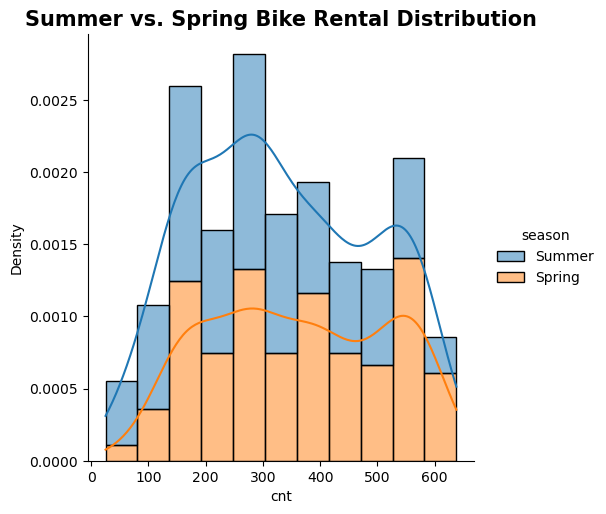

In [276]:
plot_hist_kde(df_agg_yr0)

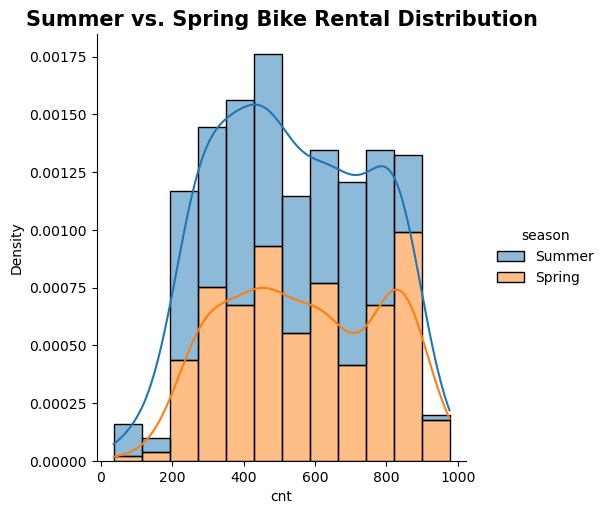

In [277]:
plot_hist_kde(df_agg_yr1)